<a href="https://colab.research.google.com/github/Ameya-20/BusinessAnalyticsProjects/blob/Walmart-TimeSeries-Forecasting/LSTM_Ameya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WALMART TIME SERIES USING LSTM

In [3]:
#Importing Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import dask.dataframe as dk
import calendar
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,Normalizer
from xgboost import XGBRegressor
from scipy.sparse import csr_matrix,hstack
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostRegressor
import catboost as cat
from sklearn.ensemble import AdaBoostRegressor
import pickle

In [4]:
#this snippet of code is used to reduce memory consumption by dataframe
dtype={'id'       :     'object',
    'item_id'     :  'int64',
    'dept_id'     :  'int8',
    'cat_id'      :  'int8',
    'store_id'    :  'int8',
    'state_id'    :  'int8',
    'd'           :  'object',
    'sales'       :  'int16',
    'date'        : 'object',
   'wday'        :  'int8',
   'month'       :  'int8',
   'year'        :  'int16',
   'event_name_1' : 'int8',
   'event_type_1' : 'int8',
   'event_name_2' : 'int8',
   'event_type_2' : 'int8',
    'snap':'int8',
  'sell_price'   : 'float16',
       'price_change':'float16',
   'week_number'  : 'int8',
   'season'       : 'object',
   'quater_start' : 'int8',
   'quater_end'   : 'int8',
   'month_start'  : 'int8',
   'month_end'    : 'int8',
   'year_start'   : 'int8',
   'year_end'     : 'int8',
   'group'        : 'int8',
   'no_events'    : 'object',
   'holiday'      : 'object',
    'week_number':'int8',
       'season':'int8',
       'quater_start':'int8',
       'quater_end':'int8',
       'month_start':'int8',
       'month_end':'int8',
       'year_start':'int8',
       'year_end':'int8',
       'roll_7_shift_28_mean':'float16',
       'roll_14_shift_28_mean':'float16',
       'roll_30_shift_28_mean':'float16',
       'roll_60_shift_28_mean':'float16',
       'roll_360_shift_28_mean':'float16',
       'roll_7_shift_28_std':'float16',
       'roll_14_shift_28_std':'float16',
       'roll_30_shift_28_std':'float16',
       'roll_60_shift_28_std':'float16',
       'roll_360_shift_28_std':'float16',
       'direct_ewm':'float16',
       'direct_lag_28':'int16',
       'direct_lag_35':'int16',
       'direct_lag_42':'int16',
       'direct_lag_49':'int16',
       'direct_lag_56':'int16',
       'direct_lag_63':'int16',
       'direct_lag_70':'int16',
       'direct_lag_77':'int16',
       'direct_lag_84':'int16',
       'direct_lag_91':'int16',
       'direct_lag_98':'int16',
       'min_price':'float16',
       'max_price':'float16',
       'mean_price':'float16',
       'std_price':'float16',
       'price_norm_1':'float16',
       'price_norm_2':'float16',
       'price_norm_3':'float16',
      }

In [22]:
cv=pd.read_csv('cv1.csv')
test=pd.read_csv('test1.csv')
final_test=pd.read_csv('final_test1.csv')

In [23]:
train=pd.read_csv('train1.csv')


# **Metric Calculation Functions**

In [20]:
def caluclate_WRMSSE(actual,predicted,train,weights,h,n):
    '''This function is used to calculate RMSSE'''
    num=((actual-predicted)**2).sum(axis=1)/h
    denom=(train[:,1:]-train[:,:-1])**2
    denom=denom.sum(axis=1)/(n-1)
    return (num/denom)**0.5

In [24]:
#Refrernce https://www.kaggle.com/qcw171717/naive-baseline/
def get_model_performances(model,train,cv,test,X_cv,X_test):
    '''This Function is used to get WRMSSE that is used in this Case Study as a Metric For CV and Test Data'''
    #For CV Data
    cv['prices']=cv['sales']*cv['sell_price']
    total_sales=cv.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i]=total_sales.loc[i]['sales']/total
    train1=pd.concat([train,cv])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    cv['pred_sales']=model.predict(X_cv)
    df1=cv.pivot_table(index=['id'],columns='d',values='pred_sales')
    dic={}
    for j,i in enumerate(range(1886,1914)):
        dic['d_'+str(i)]='F'+str(j+1)
    df1=df1.rename(columns=dic)
    df1.reset_index(level=[0],inplace=True)
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1914)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1886)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1886)
    cv_wrsmme=np.sum(rmsse*weights)
    cv.drop(['pred_sales'],axis=1,inplace=True)
    del actual,predicted,training,weights,agg

    #For Test data
    test['prices']=test['sales']*test['sell_price']
    total_sales=test.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i.replace('evaluation','validation')]=total_sales.loc[i]['sales']/total
    test['id']=test['id'].apply(lambda x:x.replace('evaluation','validation'))
    train1=pd.concat([train,cv,test])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    test['pred_sales']=model.predict(X_test)
    df1=test.pivot_table(index=['id'],columns='d',values='pred_sales')
    dic={}
    for j,i in enumerate(range(1914,1942)):
        dic['d_'+str(i)]='F'+str(j+1)
    df1=df1.rename(columns=dic)
    df1.reset_index(level=[0],inplace=True)
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1942)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919',
       'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925',
       'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931',
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937',
       'd_1938', 'd_1939', 'd_1940', 'd_1941']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1914)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1914)
    test_wrsmme=np.sum(rmsse*weights)

    print("CV WRMSSE=",cv_wrsmme)
    print("Test WRMSSE=",test_wrsmme)


In [25]:
#https://www.kaggle.com/qcw171717/naive-baseline/
def get_model_performances_for_store_wise_trained_model(train,cv,test,cv_pred,test_pred):
    '''This Function is used to get WRMSSE that is used in this Case Study as a Metric For CV and Test Data where model is trained according to store id(Mainly used for Catabosst)'''
    #For CV Data
    cv['prices']=cv['sales']*cv['sell_price']
    total_sales=cv.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i]=total_sales.loc[i]['sales']/total
    train1=pd.concat([train,cv])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc

    df1=cv_pred
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1914)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1886)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1886)
    cv_wrsmme=np.sum(rmsse*weights)
    del actual,predicted,training,weights,agg

    #For Test data
    test['prices']=test['sales']*test['sell_price']
    total_sales=test.groupby('id').sum()
    total=sum(total_sales['sales'])
    weight={}
    for i in total_sales.index:
        weight[i.replace('evaluation','validation')]=total_sales.loc[i]['sales']/total
    test['id']=test['id'].apply(lambda x:x.replace('evaluation','validation'))
    train1=pd.concat([train,cv,test])
    train1.sort_values(['id','date'],inplace=True)
    train1.fillna(0,inplace=True)
    df=train1.pivot_table(index=['id','state_id','store_id','cat_id','dept_id','item_id'],columns='d',values='sales')
    df.reset_index(level=[0,1,2,3,4,5],inplace=True)
    df.fillna(0,inplace=True)
    del train1
    import gc
    df1=test_pred
    df1['id']=df1['id'].apply(lambda x:x.replace('evaluation','validation'))
    dd=df.merge(df1,on='id')
    dd['weight']=dd['id'].apply(lambda x:weight[x])
    l=['d_'+str(i) for i in range(1,1942)]
    l1=['F'+str(i) for i in range(1,29)]
    agg_level={2:['state_id'],3:['store_id'],4:['cat_id'],5:['dept_id'],6:['state_id','cat_id'],\
           7:['state_id','dept_id'],8:['store_id','cat_id'],9:['store_id','dept_id'],10:['item_id'],11:['item_id','state_id']}
    agg=pd.DataFrame(dd[l+l1].sum()).transpose()
    agg['weight']=1/12
    agg['level']=1
    col=agg.columns
    for level in agg_level:
        temp_df=dd.groupby(by=agg_level[level]).sum().reset_index(drop=True)
        temp_df['weight']/=12
        temp_df['level']=level
        agg=agg.append(temp_df[col])
    dd['weight']/=12
    dd['level']=12
    agg=agg.append(dd[col])
    actual=agg[['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919',
       'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925',
       'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931',
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937',
       'd_1938', 'd_1939', 'd_1940', 'd_1941']].values
    predicted=agg[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28']].values
    training=agg[['d_'+str(i) for i in range(1,1914)]].values
    weights=agg['weight'].values
    rmsse=caluclate_WRMSSE(actual,predicted,training,weights,28,1914)
    test_wrsmme=np.sum(rmsse*weights)

    print("CV WRMSSE=",cv_wrsmme)
    print("Test WRMSSE=",test_wrsmme)


## **Modeling**
# 1. LSTM Network(No Date Features)

In [26]:
tf.keras.backend.clear_session()
input1=tf.keras.layers.Input(shape=1,name='Item_Id')
input2=tf.keras.layers.Input(shape=1,name='Dept_Id')
input3=tf.keras.layers.Input(shape=1,name='Cat_Id')
input4=tf.keras.layers.Input(shape=1,name='Store_Id')
input5=tf.keras.layers.Input(shape=1,name='State_Id')
input6=tf.keras.layers.Input(shape=1,name='year')
input7=tf.keras.layers.Input(shape=1,name='event_name_1')
input8=tf.keras.layers.Input(shape=1,name='event_name_2')
input9=tf.keras.layers.Input(shape=1,name='season')
input10=tf.keras.layers.Input(shape=(1,23),name='Numerical_features')

emb1=tf.keras.layers.Embedding(3050,output_dim=150)(input1)
emb2=tf.keras.layers.Embedding(8,output_dim=10)(input2)
emb3=tf.keras.layers.Embedding(4,output_dim=10)(input3)
emb4=tf.keras.layers.Embedding(11,output_dim=10)(input4)
emb5=tf.keras.layers.Embedding(4,output_dim=10)(input5)
emb6=tf.keras.layers.Embedding(2017,output_dim=10)(input6)
emb7=tf.keras.layers.Embedding(32,output_dim=10)(input7)
emb8=tf.keras.layers.Embedding(6,output_dim=10)(input8)
emb9=tf.keras.layers.Embedding(5,output_dim=10)(input9)

lstm1=tf.keras.layers.LSTM(50)(emb1)
lstm2=tf.keras.layers.LSTM(10)(emb2)
lstm3=tf.keras.layers.LSTM(10)(emb3)
lstm4=tf.keras.layers.LSTM(10)(emb4)
lstm5=tf.keras.layers.LSTM(10)(emb5)
lstm6=tf.keras.layers.LSTM(10)(emb6)
lstm7=tf.keras.layers.LSTM(10)(emb7)
lstm8=tf.keras.layers.LSTM(10)(emb8)
lstm9=tf.keras.layers.LSTM(10)(emb9)
lstm10=tf.keras.layers.LSTM(10)(input10)

x1=tf.keras.layers.Flatten()(lstm1)
x2=tf.keras.layers.Flatten()(lstm2)
x3=tf.keras.layers.Flatten()(lstm3)
x4=tf.keras.layers.Flatten()(lstm4)
x5=tf.keras.layers.Flatten()(lstm5)
x6=tf.keras.layers.Flatten()(lstm6)
x7=tf.keras.layers.Flatten()(lstm7)
x8=tf.keras.layers.Flatten()(lstm8)
x9=tf.keras.layers.Flatten()(lstm9)
x10=tf.keras.layers.Flatten()(input10)

x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='sigmoid')(x)
x=tf.keras.layers.Dense(128,activation='tanh')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],x)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item_Id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 Dept_Id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 Cat_Id (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 Store_Id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                              

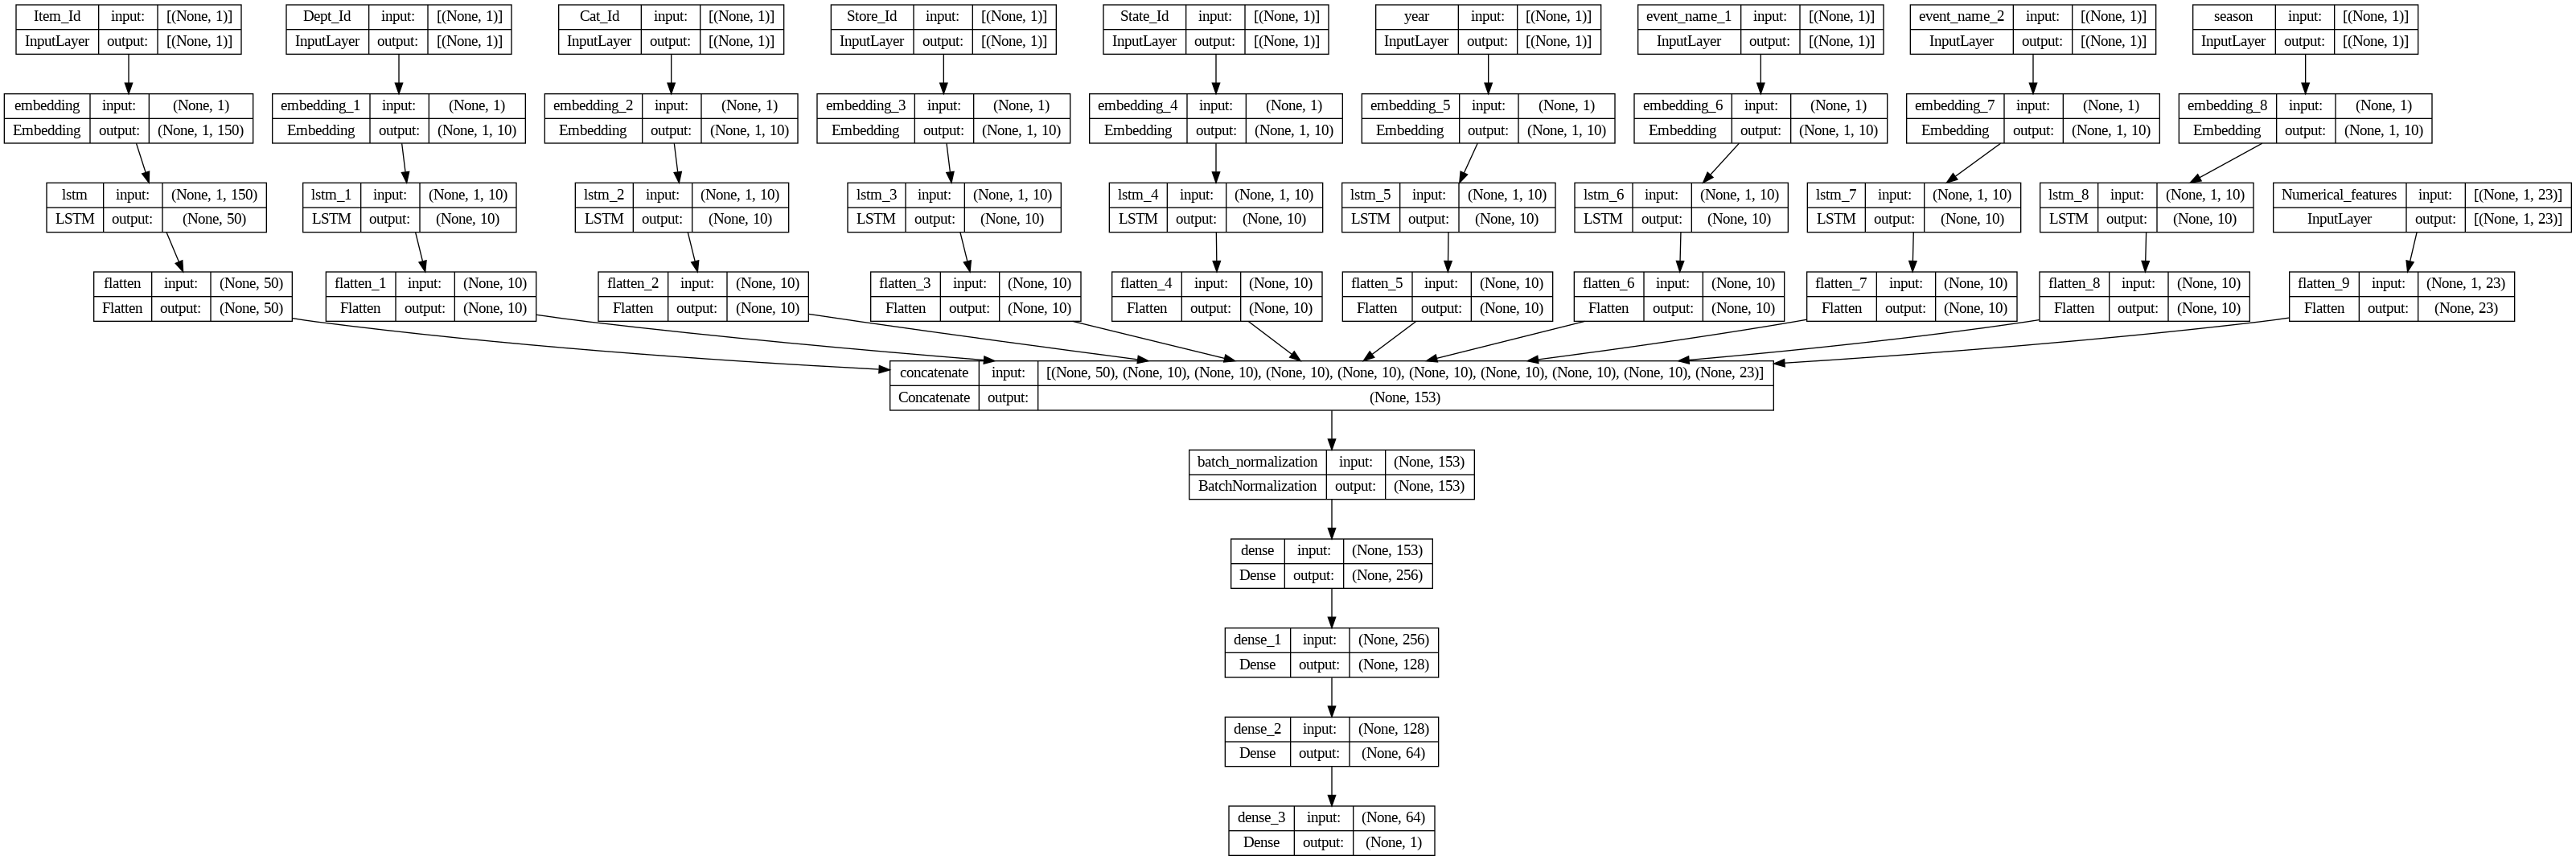

In [28]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0009),loss='mse')

In [30]:
model.fit(x=[train['item_id'].values.reshape(-1,1),train['dept_id'].values,train['cat_id'].values.reshape(-1,1),train['store_id'].values.reshape(-1,1),\
             train['state_id'].values.reshape(-1,1),train['year'].values.reshape(-1,1),train['event_name_1'].values.reshape(-1,1),train['event_name_2'].values.reshape(-1,1),\
             train['season'].values.reshape(-1,1),train[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
          y=train['sales'],epochs=15,verbose=1,batch_size=50000,\
          validation_data=([cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],cv['sales']),workers=5,use_multiprocessing=True)


Epoch 1/15
152/152 [==============================] - 36s 65ms/step - loss: 8.3904 - val_loss: 4.5376
Epoch 2/15
152/152 [==============================] - 5s 32ms/step - loss: 6.8000 - val_loss: 4.4265
Epoch 3/15
152/152 [==============================] - 5s 33ms/step - loss: 6.5993 - val_loss: 4.3353
Epoch 4/15
152/152 [==============================] - 5s 32ms/step - loss: 6.4487 - val_loss: 4.1656
Epoch 5/15
152/152 [==============================] - 5s 35ms/step - loss: 6.3212 - val_loss: 4.2412
Epoch 6/15
152/152 [==============================] - 5s 33ms/step - loss: 6.2115 - val_loss: 4.1454
Epoch 7/15
152/152 [==============================] - 5s 34ms/step - loss: 6.1161 - val_loss: 4.1571
Epoch 8/15
152/152 [==============================] - 5s 32ms/step - loss: 6.0448 - val_loss: 4.1775
Epoch 9/15
152/152 [==============================] - 5s 33ms/step - loss: 5.9785 - val_loss: 4.1749
Epoch 10/15
152/152 [==============================] - 5s 35ms/step - loss: 5.9188 - val_l

In [31]:
%%time
get_model_performances(model,train,cv,test,[cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
                       [test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])


4546/4546 [==============================] - 22s 5ms/step
CV WRMSSE= 0.8777916698353294
Test WRMSSE= 0.9222681048081814
CPU times: user 2min 8s, sys: 24.2 s, total: 2min 33s
Wall time: 1min 38s


# **Now We try to Submit It in Required Format for Kaggle**

In [32]:
#Predicting for test data
test['pred_sales']=model.predict([test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

4546/4546 [==============================] - 21s 5ms/step


In [33]:
#predicting sales for final_test data
final_test['pred_sales']=model.predict([final_test['item_id'].values.reshape(-1,1),test['dept_id'].values,final_test['cat_id'].values.reshape(-1,1),final_test['store_id'].values.reshape(-1,1),\
             final_test['state_id'].values.reshape(-1,1),final_test['year'].values.reshape(-1,1),final_test['event_name_1'].values.reshape(-1,1),final_test['event_name_2'].values.reshape(-1,1),\
             final_test['season'].values.reshape(-1,1),final_test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

4546/4546 [==============================] - 21s 5ms/step


In [34]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)

CPU times: user 82.3 ms, sys: 0 ns, total: 82.3 ms
Wall time: 81.1 ms


In [35]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)

CPU times: user 68.3 ms, sys: 1.57 ms, total: 69.9 ms
Wall time: 69.2 ms


In [36]:
df2=pd.concat([df1,df])

In [37]:
#We have then submitted this Csv file in kaggle to get scores
df2.to_csv('NN.csv',index=False)

# **2. CNN-LSTM NN(No Date Features)**

In [40]:
tf.keras.backend.clear_session()
input1=tf.keras.layers.Input(shape=1,name='Item_Id')
input2=tf.keras.layers.Input(shape=1,name='Dept_Id')
input3=tf.keras.layers.Input(shape=1,name='Cat_Id')
input4=tf.keras.layers.Input(shape=1,name='Store_Id')
input5=tf.keras.layers.Input(shape=1,name='State_Id')
input6=tf.keras.layers.Input(shape=1,name='year')
input7=tf.keras.layers.Input(shape=1,name='event_name_1')
input8=tf.keras.layers.Input(shape=1,name='event_name_2')
input9=tf.keras.layers.Input(shape=1,name='season')
input10=tf.keras.layers.Input(shape=(1,23),name='Numerical_features')

emb1=tf.keras.layers.Embedding(3050,output_dim=150)(input1)
emb1=tf.keras.layers.Conv1D(7,8,padding='same',activation='relu')(emb1)

emb2=tf.keras.layers.Embedding(8,output_dim=10)(input2)
emb2=tf.keras.layers.Conv1D(3,8,padding='same',activation='sigmoid')(emb2)

emb3=tf.keras.layers.Embedding(4,output_dim=10)(input3)
emb3=tf.keras.layers.Conv1D(5,8,padding='same',activation='relu')(emb3)

emb4=tf.keras.layers.Embedding(11,output_dim=10)(input4)
emb4=tf.keras.layers.Conv1D(5,8,padding='same',activation='tanh')(emb4)

emb5=tf.keras.layers.Embedding(4,output_dim=10)(input5)
emb5=tf.keras.layers.Conv1D(5,8,padding='same',activation='relu')(emb5)

emb6=tf.keras.layers.Embedding(2017,output_dim=10)(input6)
emb6=tf.keras.layers.Conv1D(5,8,padding='same',activation='sigmoid')(emb6)

emb7=tf.keras.layers.Embedding(32,output_dim=10)(input7)
emb7=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb7)

emb8=tf.keras.layers.Embedding(6,output_dim=10)(input8)
emb8=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb8)

emb9=tf.keras.layers.Embedding(5,output_dim=10)(input9)
emb9=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb9)

emb10=tf.keras.layers.Conv1D(3,16,padding='same',activation='tanh')(input10)

lstm1=tf.keras.layers.LSTM(50)(emb1)
lstm2=tf.keras.layers.LSTM(10)(emb2)
lstm3=tf.keras.layers.LSTM(10)(emb3)
lstm4=tf.keras.layers.LSTM(10)(emb4)
lstm5=tf.keras.layers.LSTM(10)(emb5)
lstm6=tf.keras.layers.LSTM(10)(emb6)
lstm7=tf.keras.layers.LSTM(10)(emb7)
lstm8=tf.keras.layers.LSTM(10)(emb8)
lstm9=tf.keras.layers.LSTM(10)(emb9)
lstm10=tf.keras.layers.LSTM(32)(emb10)

x1=tf.keras.layers.Flatten()(lstm1)
x2=tf.keras.layers.Flatten()(lstm2)
x3=tf.keras.layers.Flatten()(lstm3)
x4=tf.keras.layers.Flatten()(lstm4)
x5=tf.keras.layers.Flatten()(lstm5)
x6=tf.keras.layers.Flatten()(lstm6)
x7=tf.keras.layers.Flatten()(lstm7)
x8=tf.keras.layers.Flatten()(lstm8)
x9=tf.keras.layers.Flatten()(lstm9)
x10=tf.keras.layers.Flatten()(lstm10)


x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='sigmoid')(x)
x=tf.keras.layers.Dense(128,activation='tanh')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],x)

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item_Id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 Dept_Id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 Cat_Id (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 Store_Id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                              

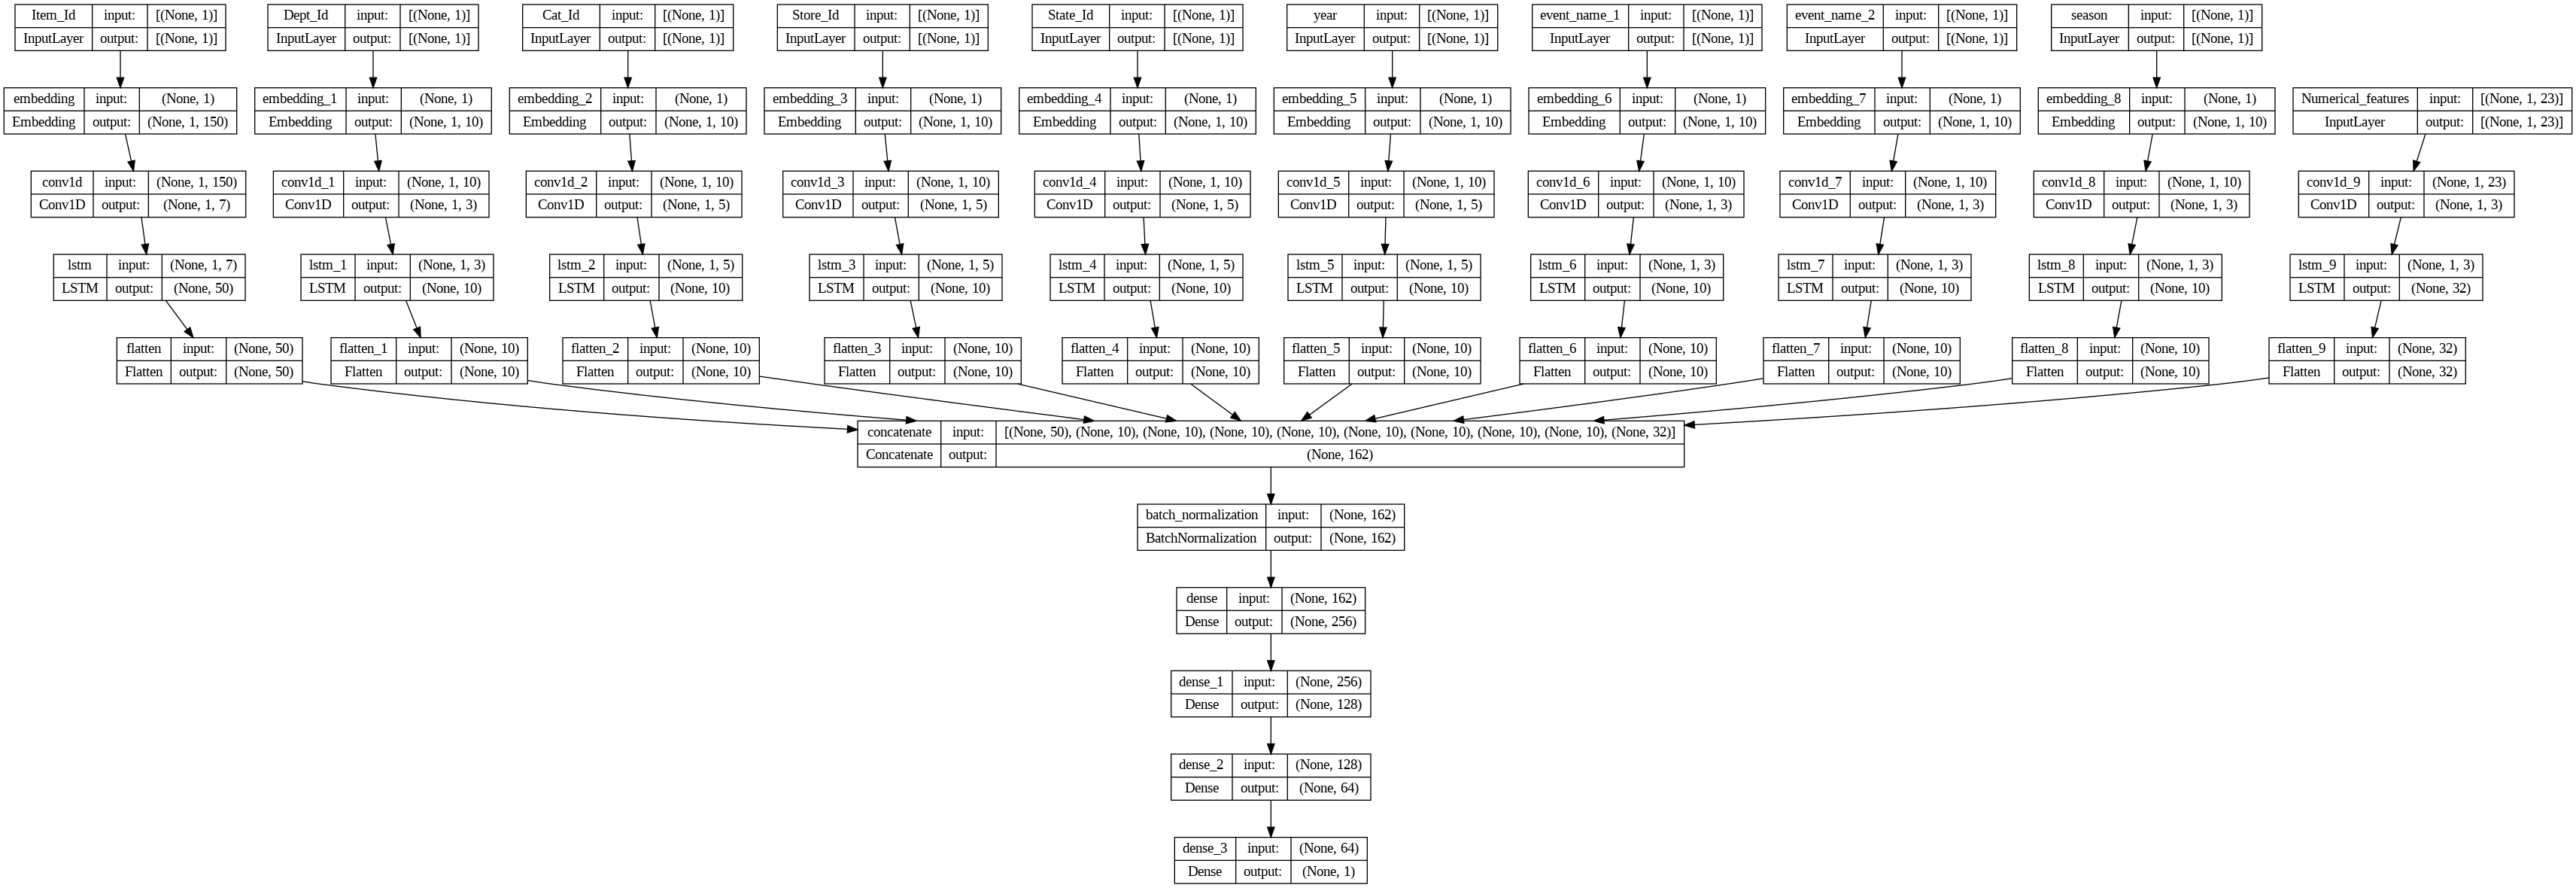

In [42]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [43]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss='mse')
model.fit(x=[train['item_id'].values.reshape(-1,1),train['dept_id'].values,train['cat_id'].values.reshape(-1,1),train['store_id'].values.reshape(-1,1),\
             train['state_id'].values.reshape(-1,1),train['year'].values.reshape(-1,1),train['event_name_1'].values.reshape(-1,1),train['event_name_2'].values.reshape(-1,1),\
             train['season'].values.reshape(-1,1),train[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
          y=train['sales'],epochs=10,verbose=1,batch_size=50000,\
          validation_data=([cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],cv['sales']),use_multiprocessing=True,workers=7)

Epoch 1/10
152/152 [==============================] - 42s 74ms/step - loss: 9.0053 - val_loss: 8.8024
Epoch 2/10
152/152 [==============================] - 7s 43ms/step - loss: 7.0675 - val_loss: 8.2216
Epoch 3/10
152/152 [==============================] - 7s 43ms/step - loss: 6.8270 - val_loss: 7.0676
Epoch 4/10
152/152 [==============================] - 6s 41ms/step - loss: 6.7282 - val_loss: 5.5337
Epoch 5/10
152/152 [==============================] - 6s 43ms/step - loss: 6.6655 - val_loss: 4.3113
Epoch 6/10
152/152 [==============================] - 6s 42ms/step - loss: 6.6068 - val_loss: 4.3203
Epoch 7/10
152/152 [==============================] - 7s 43ms/step - loss: 6.5634 - val_loss: 4.1804
Epoch 8/10
152/152 [==============================] - 6s 43ms/step - loss: 6.5000 - val_loss: 4.1336
Epoch 9/10
152/152 [==============================] - 7s 43ms/step - loss: 6.4574 - val_loss: 4.2124
Epoch 10/10
152/152 [==============================] - 6s 41ms/step - loss: 6.4407 - val_l

In [44]:
%%time
get_model_performances(model,train,cv,test,[cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
                       [test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

4546/4546 [==============================] - 27s 6ms/step
CV WRMSSE= 0.8018532998916446
Test WRMSSE= 0.8568130138174873
CPU times: user 2min 23s, sys: 25.7 s, total: 2min 48s
Wall time: 1min 49s


# **Now We try to Submit It in Required Format for Kaggle**

In [45]:
test['pred_sales']=model.predict([test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])


4546/4546 [==============================] - 27s 6ms/step


In [46]:
final_test['pred_sales']=model.predict([final_test['item_id'].values.reshape(-1,1),test['dept_id'].values,final_test['cat_id'].values.reshape(-1,1),final_test['store_id'].values.reshape(-1,1),\
             final_test['state_id'].values.reshape(-1,1),final_test['year'].values.reshape(-1,1),final_test['event_name_1'].values.reshape(-1,1),final_test['event_name_2'].values.reshape(-1,1),\
             final_test['season'].values.reshape(-1,1),final_test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

4546/4546 [==============================] - 27s 6ms/step


In [47]:
%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [48]:
df2=pd.concat([df1,df])

In [49]:
df2.to_csv('CNN.csv',index=False)